# Stock optimization for seafood distribution center

Each day a seafood distribution center buys $x$ tons of tuna at unit cost $c$ per ton. The next day a demand $z$ is observed from the retailers to whom the fish is sold at a unit price $p > c$. Any leftover tuna needs to be stored in a cold warehouse at a unit holding cost $h$. The seafood distribution center cannot sell more fish than it has in stock, thus at most $\min\{z, x \}$ tons will be sold which will leave $h(x-z)^+$ tons leftover, where $h()^+$ is the positive residual. Accounting for these costs, the net profit is

$$\text{net profit} = p \min\{z, x \} - cx - h (x-z)^+.$$

Given a reasonable estimate of the probability distribution $\mathbb P$ of the tuna demand $z$, to maximize the long-term net profit then we can formulate the following optimization problem:

$$
\max\limits_{x \geq 0} \, \mathbb E_z  [ p \min\{z, x \} - cx - h (x-z)^+ ].
$$

Since we have $x \geq 0$ regardless of the demand $z$, the feasible set for the decision variable $x$ is not affected by unknown demand.


## Explicit Solution

Suppose the unit prices for a ton of tuna are $c = 10$, $p = 25$, $h = 3$, and that the demand for tuna in tons can be modeled as a continuous random variable $\xi$. Find the optimal solution of the seafood inventory problem using the explicit formula that features the inverse CDFs/quantile functions for the following three distributions:

1. a uniform distribution on the interval $[50, 150]$. *Hint: see [Uniform distribution CDF and its inverse](https://en.wikipedia.org/wiki/Continuous_uniform_distribution#Cumulative_distribution_function)*

2.  a Pareto distribution on the interval $[50,+\infty)$ with $x_m=50$ and exponent $\alpha=2$. *Hint: the inverse CDF for a Pareto distribution is given by* $H^{-1}(\varepsilon) = \frac{x_m}{(1-\varepsilon)^{1/\alpha}}$.

3. a Weibull distribution on the interval $[0,+\infty)$ with shape parameter $k=2$ and scale parameter $\lambda=113$. See [Weibull distribution CDF and its inverse](https://en.wikipedia.org/wiki/Weibull_distribution#Cumulative_distribution_function).

In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_glpk()
helper.install_cbc()
helper.install_ipopt()

pyomo was previously installed
glpk was previously installed
cbc was previously installed
ipopt was previously installed


True

In [1]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [50]:
# Setting the parameters
c = 10
p = 25
h = 3

# quantile
q = (p - c)/(p + h)

# distribution functions
import scipy.stats as stats

uniform = stats.uniform(loc=50, scale=100)
pareto = stats.pareto(scale=50, b=2)
weibull = stats.weibull_min(scale=113, c=2)

In [78]:
print(stats.uniform(loc=50, scale=100).ppf(q))
print(stats.pareto(scale=50, b=2).ppf(q))
print(stats.weibull_min(scale=113, c=2).ppf(q))

103.57142857142857
73.37993857053428
98.98020531904758


Plotting the distributions

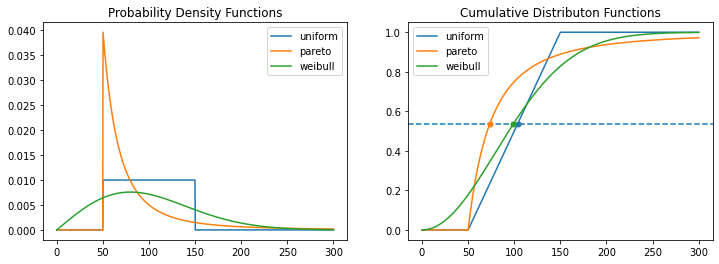

In [77]:
x = np.linspace(0, 300, 1000)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

lu = ax[0].plot(x, uniform.pdf(x), label="uniform")
lp = ax[0].plot(x, pareto.pdf(x), label="pareto")
lw = ax[0].plot(x, weibull.pdf(x), label="weibull")
ax[0].set_title("Probability Density Functions")
ax[0].legend()

ax[1].plot(x, uniform.cdf(x), label="uniform")
ax[1].plot(x, pareto.cdf(x), label="pareto")
ax[1].plot(x, weibull.cdf(x), label="weibull")
ax[1].set_title("Cumulative Distributon Functions")
ax[1].legend()

ax[1].axhline(q, linestyle='--')
ax[1].plot(uniform.ppf(q), q, '.', color=lu[0].get_color(), ms=10)
ax[1].plot(pareto.ppf(q), q, '.', color=lp[0].get_color(), ms=10)
ax[1].plot(weibull.ppf(q), q, '.', color=lw[0].get_color(), ms=10)

In [3]:
# Definining the three inverse CDFs/quantile functions for the three distributions
def quantileuniform(epsilon, a, b):
    return a + epsilon*(b-a)

def quantilepareto(epsilon, xm, alpha):
    return xm/(1.0-epsilon)**(1.0/alpha)

def quantileweibull(epsilon, k, l):
    return l*(-np.log(1-epsilon))**(1.0/k)

# Calculating the optimal decision for each of the three distributions
display(Markdown(f"**Optimal solution** for uniform distribution: ${quantileuniform((p-c)/(p+h),50,150):.2f}$ tons"))
display(Markdown(f"**Optimal solution** for Pareto distribution: ${quantilepareto((p-c)/(p+h),50,2):.2f}$ tons"))
display(Markdown(f"**Optimal solution** for Weibull distribution: ${quantileweibull((p-c)/(p+h),2,113):.2f}$ tons"))

**Optimal solution** for uniform distribution: $103.57$

**Optimal solution** for Pareto distribution: $73.38$

**Optimal solution** for Weibull distribution: $98.98$

Note that all the three distribution above have the same expected value, that is $\mathbb E \xi = 100$ tons.

(b) Find the optimal solution of the deterministic LP model obtained by assuming the demand is fixed $\xi=\bar{\xi}$ and equal to the average demand $\bar{\xi} = \mathbb E \xi = 100$.

In [4]:

c = 10
p = 25
h = 3

m = pyo.ConcreteModel()
m.xi = 100

# first stage variable
m.x = pyo.Var(domain=pyo.NonNegativeReals)

@m.Expression()
def first_stage_profit(m):
    return -c * m.x

# second stage variables
model.y = pyo.Var(domain=pyo.NonNegativeReals)
model.z = pyo.Var(domain=pyo.NonNegativeReals)

# second stage constraints
model.cantsoldfishidonthave = pyo.Constraint(expr=model.y <= model.xi)
model.fishdonotdisappear = pyo.Constraint(expr=model.y + model.z == model.x)

def second_stage_profit(model):
    return p * model.y - h * model.z

model.second_stage_profit = pyo.Expression(rule=second_stage_profit)

def total_profit(model):
    return model.first_stage_profit + model.second_stage_profit

model.total_expected_profit = pyo.Objective(rule=total_profit, sense=pyo.maximize)

result = cbc_solver.solve(model)

display(Markdown(f"**Solver status:** *{result.solver.status}, {result.solver.termination_condition}*"))
display(Markdown(f"**Optimal solution** for determistic demand equal to $100$: $x = {model.x.value:.1f}$"))
display(Markdown(f"**Optimal deterministic profit:** ${model.total_expected_profit():.0f}$€"))

**Solver status:** *ok, optimal*

**Optimal solution** for determistic demand equal to $100$: $x = 100.0$

**Optimal deterministic profit:** $1500$€

We now assess how well we perform taking the average demand as input for each of the three demand distributions above.

(c) For a fixed decision variable $x=100$, approximate the expected net profit of the seafood distribution center for each of the three distributions above using the Sample Average Approximation method with $N=2500$ points. More specifically, generate $N=2500$ samples from the considered distribution and solve the extensive form of the stochastic LP resulting from those $N=2500$ scenarios.

In [5]:
# Two-stage stochastic LP

c = 10
p = 25
h = 3

# SAA of the two-stage stochastic LP to calculate the expected profit when buying the average

def NaiveSeafoodStockSAA(N, sample, distributiontype):

    model = pyo.ConcreteModel()

    def indices_rule(model):
        return range(N)
    model.indices = pyo.Set(initialize=indices_rule)
    model.xi = pyo.Param(model.indices, initialize=dict(enumerate(sample)))

    # first stage variable
    model.x = 100.0 #bought

    def first_stage_profit(model):
        return -c * model.x

    model.first_stage_profit = pyo.Expression(rule=first_stage_profit)

    # second stage variables
    model.y = pyo.Var(model.indices, within=pyo.NonNegativeReals) #sold
    model.z = pyo.Var(model.indices, within=pyo.NonNegativeReals) #unsold to be stored in cold warehouse 

    # second stage constraints
    model.cantsoldthingsfishdonthave = pyo.ConstraintList()
    model.fishdonotdisappear = pyo.ConstraintList()
    for i in model.indices:
        model.cantsoldthingsfishdonthave.add(expr=model.y[i] <= model.xi[i])
        model.fishdonotdisappear.add(expr=model.y[i] + model.z[i] == model.x)

    def second_stage_profit(model):
        return sum([p * model.y[i] - h * model.z[i] for i in model.indices])/float(N)

    model.second_stage_profit = pyo.Expression(rule=second_stage_profit)

    def total_profit(model):
        return model.first_stage_profit + model.second_stage_profit

    model.total_expected_profit = pyo.Objective(rule=total_profit, sense=pyo.maximize)

    result = cbc_solver.solve(model)

    display(Markdown(f"**Approximate expected optimal profit when using the average** $x=100$ with {distributiontype} demand: ${model.total_expected_profit():.2f}$€"))
    return model.total_expected_profit()

np.random.seed(20122020)
N = 2500

samples = np.random.uniform(low=50.0, high=150.0, size=N)
naiveprofit_uniform = NaiveSeafoodStockSAA(N, samples, 'uniform')

shape = 2
xm = 50
samples = (np.random.pareto(a=shape, size=N) + 1) *  xm
naiveprofit_pareto = NaiveSeafoodStockSAA(N, samples, 'Pareto')

shape=2
scale=113
samples = scale*np.random.weibull(a=shape, size=N)
naiveprofit_weibull = NaiveSeafoodStockSAA(N, samples, 'Weibull')

**Approximate expected optimal profit when using the average** $x=100$ with uniform demand: $1143.79$€

**Approximate expected optimal profit when using the average** $x=100$ with Pareto demand: $813.34$€

**Approximate expected optimal profit when using the average** $x=100$ with Weibull demand: $923.81$€

(d) Solve approximately the stock optimization problem for each of the three distributions above using the Sample Average Approximation method with $N=2500$ points. More specifically, generate $N=2500$ samples from the considered distribution and solve the extensive form of the stochastic LP resulting from those $N=2500$ scenarios. For each of the three distribution, compare the optimal expected profit with that obtained in (c) and calculate the value of the stochastic solution (VSS).

In [6]:
# Two-stage stochastic LP for uniform distribution

c = 10
p = 25
h = 3

def SeafoodStockSAA(N, sample, distributiontype):

    model = pyo.ConcreteModel()

    def indices_rule(model):
        return range(N)
    model.indices = pyo.Set(initialize=indices_rule)
    model.xi = pyo.Param(model.indices, initialize=dict(enumerate(sample)))

    # first stage variable
    model.x = pyo.Var(within=pyo.NonNegativeReals) #bought

    def first_stage_profit(model):
        return -c * model.x

    model.first_stage_profit = pyo.Expression(rule=first_stage_profit)

    # second stage variables
    model.y = pyo.Var(model.indices, within=pyo.NonNegativeReals) #sold
    model.z = pyo.Var(model.indices, within=pyo.NonNegativeReals) #unsold to be returned 

    # second stage constraints
    model.cantsoldfishidonthave = pyo.ConstraintList()
    model.fishdonotdisappear = pyo.ConstraintList()
    for i in model.indices:
        model.cantsoldfishidonthave.add(expr=model.y[i] <= model.xi[i])
        model.fishdonotdisappear.add(expr=model.y[i] + model.z[i] == model.x)

    def second_stage_profit(model):
        return sum([p * model.y[i] - h * model.z[i] for i in model.indices])/float(N)

    model.second_stage_profit = pyo.Expression(rule=second_stage_profit)

    def total_profit(model):
        return model.first_stage_profit + model.second_stage_profit

    model.total_expected_profit = pyo.Objective(rule=total_profit, sense=pyo.maximize)

    result = cbc_solver.solve(model)

    display(Markdown(f"**Approximate solution in the case of** {distributiontype} distribution using $N={N:.0f}$ points"))
    display(Markdown(f"**Solver status:** *{result.solver.status}, {result.solver.termination_condition}*"))
    display(Markdown(f"**Approximate optimal solution:** $x = {model.x.value:.2f}$ tons"))
    display(Markdown(f"**Approximate expected optimal profit:** ${model.total_expected_profit():.2f}$€"))
    return model.total_expected_profit()

np.random.seed(20122020)
N = 2500

samples = np.random.uniform(low=50.0, high=150.0, size=N)
smartprofit_uniform = SeafoodStockSAA(N, samples, 'uniform')
display(Markdown(f"**Value of the stochastic solution:** ${smartprofit_uniform:.2f}-{naiveprofit_uniform:.2f} = {smartprofit_uniform-naiveprofit_uniform:.2f}$€"))

shape = 2
xm = 50
samples = (np.random.pareto(a=shape, size=N) + 1) *  xm
smartprofit_pareto = SeafoodStockSAA(N, samples, 'Pareto')
display(Markdown(f"**Value of the stochastic solution:** ${smartprofit_pareto:.2f}-{naiveprofit_pareto:.2f} = {smartprofit_pareto-naiveprofit_pareto:.2f}$€"))

shape = 2
scale = 113
samples = scale*np.random.weibull(a=shape, size=N)
smartprofit_weibull = SeafoodStockSAA(N, samples, 'Weibull')
display(Markdown(f"**Value of the stochastic solution:** ${smartprofit_weibull:.2f}-{naiveprofit_weibull:.2f} = {smartprofit_weibull-naiveprofit_weibull:.2f}$€"))

**Approximate solution in the case of** uniform distribution using $N=2500$ points

**Solver status:** *ok, optimal*

**Approximate optimal solution:** $x = 102.46$

**Approximate expected optimal profit:** $1144.60$€

**Value of the stochastic solution:** $1144.60-1143.79 = 0.82$€

**Approximate solution in the case of** Pareto distribution using $N=2500$ points

**Solver status:** *ok, optimal*

**Approximate optimal solution:** $x = 74.55$

**Approximate expected optimal profit:** $896.84$€

**Value of the stochastic solution:** $896.84-813.34 = 83.50$€

**Approximate solution in the case of** Weibull distribution using $N=2500$ points

**Solver status:** *ok, optimal*

**Approximate optimal solution:** $x = 100.38$

**Approximate expected optimal profit:** $923.84$€

**Value of the stochastic solution:** $923.84-923.81 = 0.02$€